In [50]:
import pandas as pd
import plotly.express as px
import json
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.io as pio

In [36]:
!pip install folium

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/b9/98/9ba4b9d2d07dd32765ddb4e4c189dcbdd7dca4d5a735e2e4ea756f40c36b/folium-0.16.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/17/ce/14166d0e273d12065516625fb02426350298e7b4ba59198b5fe454b46202/branca-0.7.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/100.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/100.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/100.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/100.0 kB ? eta -:--:--
   ----------- --------------------------- 30.7/100.0 kB 262.6 kB/s eta 0:00:01
   --------------------------- ----------- 71.7/100.0 kB 393.8 kB/s eta 0:00:01
   -------------------------------------- 100.0/100.0 kB 480.1 kB/s eta 0:00:00


In [37]:
import folium

In [48]:
import folium
import requests

# Define the world map centered around Africa with a low zoom level
africa_map = folium.Map(location=[0, 20], zoom_start=3, min_zoom=4, max_zoom=5)

# Define the bounds of the cocoa belt (15 degrees north and south of the equator)
north_bound = 15
south_bound = -15

# Create a rectangle to represent the cocoa belt
folium.Rectangle(
    bounds=[[south_bound, -25], [north_bound, 50]],  # Longitudes are approximate
    color='#ff7800',
    fill=True,
    fill_color='#ff7800',
    fill_opacity=0.2,
    popup='Cocoa Belt'
).add_to(africa_map)

# List of countries to highlight
countries = [
    'Cameroon', 'Republic of the Congo', "Ivory Coast",
    'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
    'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone',
    'Togo'
]

# Load GeoJSON for the whole world
geojson_url = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'
geojson_data = requests.get(geojson_url).json()

# Function to style the GeoJSON overlay
def style_function(feature):
    if feature['properties']['name'] in countries:
        return {
            'fillColor': '#90EE90',  # Light green color
            'color': '#90EE90',  # Light green outline
            'weight': 1.5,
            'fillOpacity': 0.5
        }
    else:
        # Make non-relevant countries have no outline and be fully transparent
        return {
            'fillOpacity': 0,  # Fully transparent fill
            'weight': 0,  # No outline
        }

# Add the GeoJSON overlay
folium.GeoJson(
    geojson_data,
    style_function=style_function,
    name='geojson'
).add_to(africa_map)

# Display the map
africa_map


In [4]:
# The data was downladed from https://www.fao.org/faostat/en/#data/QCL
# Open the data and do some digging
file_path = '../data/raw/FAOSTAT_data_en_4-5-2024-combined.csv'

df = pd.read_csv(file_path)


In [5]:
df.head(10)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1961,1961,t,75100.0,A,Official figure,NaN
1,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1962,1962,t,76000.0,A,Official figure,NaN
2,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1963,1963,t,85000.0,A,Official figure,NaN
3,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1964,1964,t,91200.0,A,Official figure,NaN
4,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1965,1965,t,78800.0,A,Official figure,NaN
5,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1966,1966,t,86500.0,A,Official figure,NaN
6,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1967,1967,t,93000.0,A,Official figure,NaN
7,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1968,1968,t,102000.0,A,Official figure,NaN
8,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1969,1969,t,108186.0,A,Official figure,NaN
9,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1970,1970,t,133770.0,A,Official figure,NaN


In [6]:
# The cocoa producing countries on the cocoa belt !
df["Area"].unique()

array(['Cameroon', 'Congo', "Côte d'Ivoire",
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone',
       'Togo'], dtype=object)

In [7]:
# Some of the columns need to be dropped or renamed
df.columns

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')

In [8]:
# Dropping the columns that are not of interest and renamin some of them

new_df = df.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)','Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code',
       'Flag', 'Flag Description', 'Note', 'Unit'], inplace=False)


In [9]:
new_df.rename(columns={"Area": "Country", "Value": "Cocoa Production (tons)"}, inplace =True)

In [10]:
new_df.head()

,Country,Year,Cocoa Production (tons)
0,Cameroon,1961,75100.0
1,Cameroon,1962,76000.0
2,Cameroon,1963,85000.0
3,Cameroon,1964,91200.0
4,Cameroon,1965,78800.0


In [11]:
new_df.describe()

,Year,Cocoa Production (tons)
count,682.000000,6.820000e+02
mean,1991.500000,1.711839e+05
std,17.908665,3.475006e+05
min,1961.000000,1.000000e+02
25%,1976.000000,4.000000e+03
50%,1991.500000,1.135000e+04
75%,2007.000000,2.011250e+05
max,2022.000000,2.235043e+06


In [12]:
# Round the Cocoa Production(tons) to whole numbers for better readability
new_df["Cocoa Production (tons)"] = new_df["Cocoa Production (tons)"].round(0).astype(int)

In [13]:

new_df.head()

,Country,Year,Cocoa Production (tons)
0,Cameroon,1961,75100
1,Cameroon,1962,76000
2,Cameroon,1963,85000
3,Cameroon,1964,91200
4,Cameroon,1965,78800


In [14]:
# No missing values
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Country                  682 non-null    object
 1   Year                     682 non-null    int64 
 2   Cocoa Production (tons)  682 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 13.4+ KB


In [15]:
# The data is in long format which is good for dotabases but not good for readability and analysis

pivoted_df = new_df.pivot(index="Country", columns="Year", values="Cocoa Production (tons)")

In [16]:
pivoted_df.head(10)

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Cameroon,75100,76000,85000,91200,78800,86500,93000,102000,108186,133770,...,275000,269228,310000,344752,322248,317530,301255,280077,295000,300000
Congo,900,630,800,1100,800,877,1144,1288,1195,1344,...,5000,5000,2500,3800,3500,4500,5000,7000,16000,20000
Côte d'Ivoire,85000,110000,115000,139069,121772,149662,146640,144476,180706,179156,...,1448992,1637778,1796000,1634000,2034000,2113189,2235043,2200000,2228459,2230000
Democratic Republic of the Congo,5800,6500,5600,4800,4300,5300,4900,4500,4900,6200,...,2000,3000,6000,10200,13500,18475,22058,26337,20000,20000
Equatorial Guinea,26000,30900,33000,35100,35400,38200,33600,38000,28000,35000,...,700,892,1000,1000,1000,1000,1000,1000,600,1000
Gabon,3190,3360,3600,4000,2170,4296,4061,4751,4366,6095,...,200,203,100,100,100,100,100,100,100,100
Ghana,415200,428100,427800,580500,415800,381100,423500,327000,414300,406000,...,835466,858720,858720,858720,969300,904700,811700,800000,1047385,1108663
Nigeria,197000,182000,223000,298300,184600,267200,238000,191800,220800,304800,...,367000,329870,302066,298029,250000,270000,250000,357608,280000,280000
Sao Tome and Principe,9100,9600,7800,10700,8900,10900,10900,10600,9100,9700,...,2617,3200,3000,3001,3501,3046,3000,3000,3000,3000


In [17]:
pivoted_df.columns

Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022],
      dtype='int64', name='Year')

In [18]:
pivoted_df.index

Index(['Cameroon', 'Congo', 'Côte d'Ivoire',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone', 'Togo'],
      dtype='object', name='Country')

In [19]:
pivoted_df.describe()

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
mean,75607.272727,78479.090909,83528.181818,107768.090909,79074.727273,87715.363636,88904.727273,77223.090909,90812.272727,101367.727273,...,2.697114e+05,2.861050e+05,3.001260e+05,2.919370e+05,3.322320e+05,3.354718e+05,3.322185e+05,3.369202e+05,3.559585e+05,3.631603e+05
std,127329.846312,129527.865763,133358.268346,180989.033801,126804.298767,127981.166954,134478.554281,105556.773149,132485.099117,140321.576937,...,4.699139e+05,5.197525e+05,5.621232e+05,5.176907e+05,6.349452e+05,6.498279e+05,6.778139e+05,6.662511e+05,6.953912e+05,7.015001e+05
min,900.000000,630.000000,800.000000,1100.000000,800.000000,877.000000,1144.000000,1288.000000,1195.000000,1344.000000,...,2.000000e+02,2.030000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
25%,4495.000000,5640.000000,4600.000000,4400.000000,3640.000000,4917.000000,4480.500000,4895.000000,4633.000000,6147.500000,...,2.308500e+03,3.100000e+03,2.750000e+03,3.400500e+03,3.500500e+03,3.773000e+03,4.000000e+03,5.000000e+03,6.500000e+03,8.500000e+03
50%,11550.000000,11400.000000,13900.000000,17500.000000,14300.000000,16300.000000,18338.000000,20000.000000,23600.000000,27900.000000,...,1.485000e+04,1.708200e+04,1.000000e+04,1.020000e+04,1.350000e+04,1.847500e+04,1.464800e+04,1.800000e+04,1.600000e+04,2.000000e+04
75%,80050.000000,93000.000000,100000.000000,115134.500000,100286.000000,118081.000000,119820.000000,123238.000000,144446.000000,156463.000000,...,3.210000e+05,2.995490e+05,3.060330e+05,3.213905e+05,2.861240e+05,2.937650e+05,2.756275e+05,3.188425e+05,2.875000e+05,2.900000e+05
max,415200.000000,428100.000000,427800.000000,580500.000000,415800.000000,381100.000000,423500.000000,327000.000000,414300.000000,406000.000000,...,1.448992e+06,1.637778e+06,1.796000e+06,1.634000e+06,2.034000e+06,2.113189e+06,2.235043e+06,2.200000e+06,2.228459e+06,2.230000e+06


In [20]:
# Adding a total production row per year across all countries to show the overall production trends.
total_production_per_year = pivoted_df.sum(axis=0)
total_production_df = total_production_per_year.to_frame(name="Total Production")
total_production_df.reset_index(inplace=True)
total_production_df.rename(columns={"index":"Year"}, inplace=True)

total_production_df.head()

# IDEA: I can have the total production as a bar and the bar can be 

,Year,Total Production
0,1961,831680
1,1962,863270
2,1963,918810
3,1964,1185449
4,1965,869822


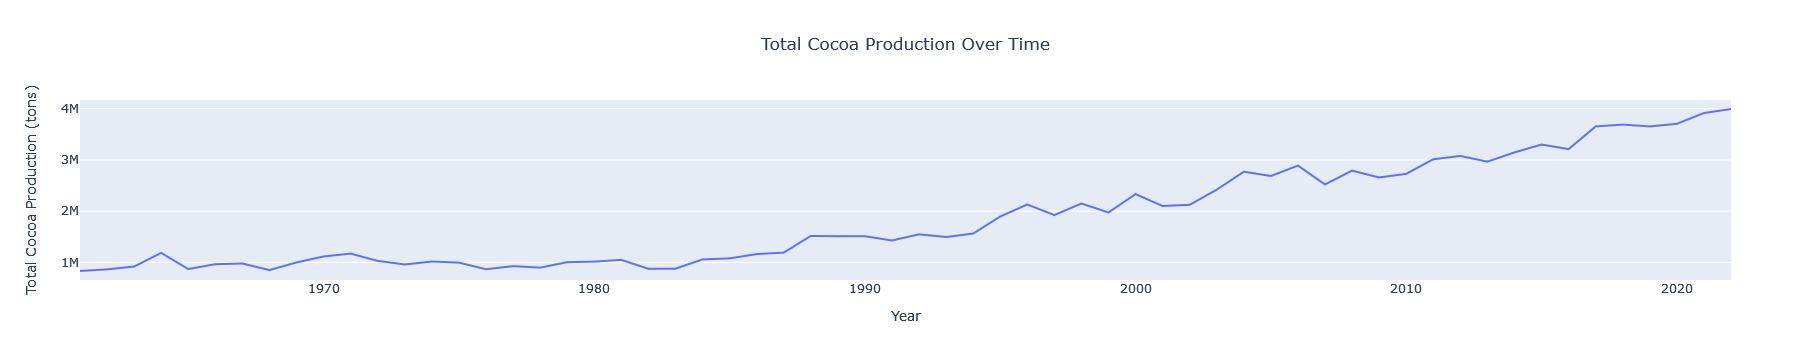

In [49]:
fig_total_production = px.line(total_production_df, x='Year', y='Total Production', title='Total Cocoa Production Over Time')

fig_total_production.update_layout(
    xaxis_title='Year',
    yaxis_title='Total Cocoa Production (tons)',
    title_x=0.5,
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=True),   
)


fig_total_production.show()



In [51]:
pio.write_html(fig_total_production, file="total_production.html")

In [22]:
# Now I need to pivot this and add to the rest. Have the total and different colors as different countries.

pivoted_df.head()

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Cameroon,75100,76000,85000,91200,78800,86500,93000,102000,108186,133770,...,275000,269228,310000,344752,322248,317530,301255,280077,295000,300000
Congo,900,630,800,1100,800,877,1144,1288,1195,1344,...,5000,5000,2500,3800,3500,4500,5000,7000,16000,20000
Côte d'Ivoire,85000,110000,115000,139069,121772,149662,146640,144476,180706,179156,...,1448992,1637778,1796000,1634000,2034000,2113189,2235043,2200000,2228459,2230000
Democratic Republic of the Congo,5800,6500,5600,4800,4300,5300,4900,4500,4900,6200,...,2000,3000,6000,10200,13500,18475,22058,26337,20000,20000
Equatorial Guinea,26000,30900,33000,35100,35400,38200,33600,38000,28000,35000,...,700,892,1000,1000,1000,1000,1000,1000,600,1000


In [23]:
grouped_df = new_df.groupby(["Year", "Country"])["Cocoa Production (tons)"].sum().unstack()


In [24]:
grouped_df.head(10)

Country,Cameroon,Congo,Côte d'Ivoire,Democratic Republic of the Congo,Equatorial Guinea,Gabon,Ghana,Nigeria,Sao Tome and Principe,Sierra Leone,Togo
Year,,,,,,,,,,,
1961,75100,900,85000,5800,26000,3190,415200,197000,9100,2840,11550
1962,76000,630,110000,6500,30900,3360,428100,182000,9600,4780,11400
1963,85000,800,115000,5600,33000,3600,427800,223000,7800,3310,13900
1964,91200,1100,139069,4800,35100,4000,580500,298300,10700,3180,17500
1965,78800,800,121772,4300,35400,2170,415800,184600,8900,2980,14300
1966,86500,877,149662,5300,38200,4296,381100,267200,10900,4534,16300
1967,93000,1144,146640,4900,33600,4061,423500,238000,10900,3869,18338
1968,102000,1288,144476,4500,38000,4751,327000,191800,10600,5039,20000
1969,108186,1195,180706,4900,28000,4366,414300,220800,9100,3782,23600


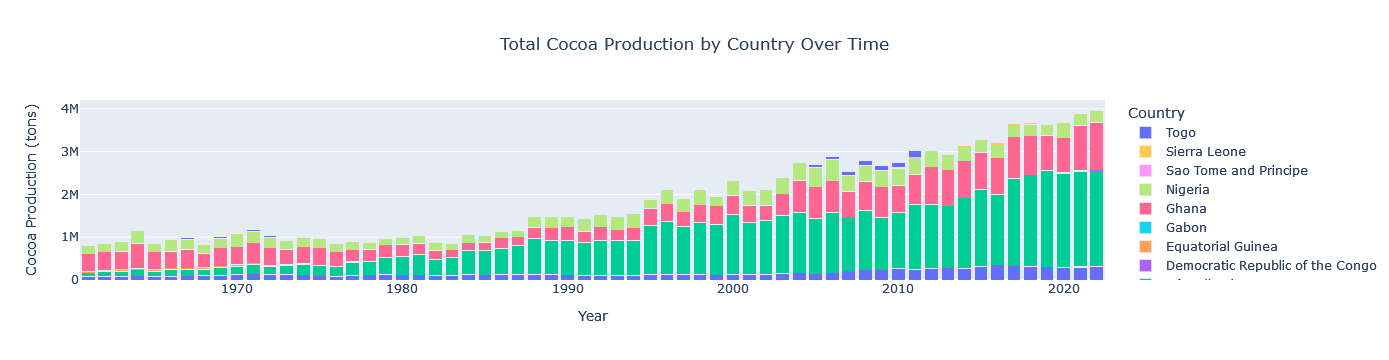

In [25]:
fig = go.Figure()

# Add a bar for each country
for country in grouped_df.columns:
    fig.add_trace(go.Bar(
        x=grouped_df.index,  # Years
        y=grouped_df[country],  # Production values
        name=country  # Country name for the legend
    ))

# Update the layout to stack the bars
fig.update_layout(
    barmode='stack',
    title={'text': "Total Cocoa Production by Country Over Time", 'x': 0.5},
    xaxis_title="Year",
    yaxis_title="Cocoa Production (tons)",
    legend_title="Country",
)

# Show the figure
fig.show()

# Hard to see the lower production countries

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming 'grouped_df' is your DataFrame and you've identified high and low production countries
high_prod_countries = ['Nigeria', 'Ghana', 'Côte d\'Ivoire', 'Cameroon']
low_prod_countries = [country for country in grouped_df.columns if country not in high_prod_countries]

# Define a color sequence that will be used for both high and low production countries
color_sequence_high = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Example colors for high production countries
color_sequence_low = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Example colors for low production

# Create the subplot figure
fig = make_subplots(rows=2, cols=1, subplot_titles=('High Production Countries', 'Low Production Countries'))

# Add traces for high production countries
for i, country in enumerate(high_prod_countries):
    fig.add_trace(
        go.Bar(
            x=grouped_df.index,  # The years
            y=grouped_df[country],
            name=country,
            marker_color=color_sequence_high[i]  # Set the bar color using the sequence
        ),
        row=1, col=1
    )

# Add traces for low production countries
for i, country in enumerate(low_prod_countries):
    # Use modulo to cycle through the color sequence for low production countries
    color = color_sequence_low[i % len(color_sequence_low)]
    fig.add_trace(
        go.Bar(
            x=grouped_df.index,  # The years
            y=grouped_df[country],
            name=country,
            marker_color=color  # Set the bar color
        ),
        row=2, col=1
    )

# Update the layout
fig.update_layout(
    barmode='stack',
    title={'text': "Cocoa Production Comparison", 'x': 0.5},
    xaxis_title="Year",
    yaxis_title="Cocoa Production (tons)",
    legend_title="Country",
    height=800
)

# Show the figure
fig.show()


In 1967 EG was a well known world cocoa producer with 38 thousand tons and the Cocoa
from EG was graded the best in the world. As a result of the political crisis that started
short after independence with President Francisco Macias Nguema Biyogo, the economy
of EG collapsed, the cocoa production felled. The oil industry has contributed in the
people attitude to abandoning the farms and as a result, despite the Governments
efforts, production of cocoa remains very small and the quality is no longer what it used
to be.

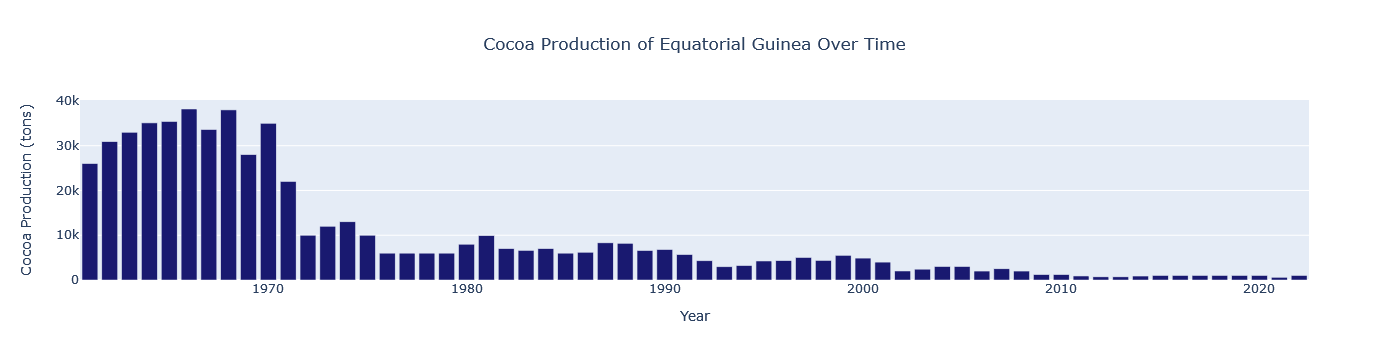

In [28]:
# Equatorial Guinea there is something wrong with the prodcution


# Extract the production data for Equatorial Guinea
equatorial_guinea_production = grouped_df['Equatorial Guinea']

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(
        x=grouped_df.index,  # The years
        y=equatorial_guinea_production,
        marker_color='midnightblue'  # Example color
    )
])

# Update the layout
fig.update_layout(
    title={'text': "Cocoa Production of Equatorial Guinea Over Time", 'x': 0.5},
    xaxis_title="Year",
    yaxis_title="Cocoa Production (tons)",
    showlegend=False
)

# Show the figure
fig.show()



In [ ]:
# year over year growth calculation to see the decline

In [ ]:
#Cluster Analysis: If you're interested in grouping countries with similar production patterns, consider applying clustering techniques.
#First we scale the values for K-means it is important as the algorihtm is sensitive to the scale of the data

In [30]:
#Extract just the values for scaling
values = grouped_df.values

# Instatiate the scaler
scaler = StandardScaler()

# Fit and transform the production values; this does not include the index (years)
scaled_values = scaler.fit_transform(values)

# Create a new DataFrame with the scaled values
scaled_df = pd.DataFrame(scaled_values, columns=grouped_df.columns, index=grouped_df.index)


In [31]:
scaled_df

Country,Cameroon,Congo,Côte d'Ivoire,Democratic Republic of the Congo,Equatorial Guinea,Gabon,Ghana,Nigeria,Sao Tome and Principe,Sierra Leone,Togo
Year,,,,,,,,,,,
1961,-1.086811,-0.545096,-1.271142,-0.282167,1.481322,0.704453,-0.289067,-0.872393,1.322756,-1.070462,-0.391836
1962,-1.074974,-0.632587,-1.232484,-0.129815,1.918818,0.799670,-0.236055,-1.050594,1.493567,-0.875623,-0.397193
1963,-0.956601,-0.577500,-1.224752,-0.325696,2.106317,0.934094,-0.237288,-0.563512,0.878647,-1.023259,-0.307911
1964,-0.875055,-0.480289,-1.187534,-0.499813,2.293815,1.158134,0.390222,0.331056,1.869351,-1.036315,-0.179344
1965,-1.038147,-0.577500,-1.214281,-0.608636,2.320601,0.133150,-0.286601,-1.019706,1.254431,-1.056401,-0.293625
...,...,...,...,...,...,...,...,...,...,...,...
2018,2.101760,0.621444,1.865072,2.476494,-0.750803,-1.026258,1.722501,-0.005149,-0.745425,3.680994,-0.536473
2019,1.887702,0.783464,2.053496,3.256319,-0.750803,-1.026258,1.340324,-0.242750,-0.761140,0.115444,-0.425763
2020,1.609157,1.431542,1.999309,4.187625,-0.750803,-1.026258,1.292243,1.035639,-0.761140,0.452093,-0.340052


In [32]:
scaled_df.describe()

Country,Cameroon,Congo,Côte d'Ivoire,Democratic Republic of the Congo,Equatorial Guinea,Gabon,Ghana,Nigeria,Sao Tome and Principe,Sierra Leone,Togo
count,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01
mean,7.879002e-17,5.730183e-17,7.879002e-17,1.146037e-16,2.148819e-17,-7.162729e-18,-4.297638e-17,-8.953411e-18,-1.539987e-16,-8.774343e-17,-4.924376e-17
std,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00,1.008163e+00
min,-1.086811e+00,-6.325870e-01,-1.271142e+00,-1.109222e+00,-7.865173e-01,-1.026258e+00,-1.310262e+00,-1.549556e+00,-1.156397e+00,-1.070462e+00,-6.578967e-01
25%,-6.633452e-01,-4.435912e-01,-1.005117e+00,-4.073137e-01,-6.612282e-01,-9.702475e-01,-7.880377e-01,-8.545731e-01,-7.611398e-01,-7.496055e-01,-4.526817e-01
50%,-4.304992e-01,-2.251079e-01,-1.530319e-01,-3.028437e-01,-3.412977e-01,-2.208331e-01,-3.029159e-01,-1.013777e-01,-4.577793e-01,-1.637080e-01,-3.061250e-01
75%,5.711030e-01,-3.481591e-02,7.231641e-01,-9.620298e-03,8.119175e-03,9.189712e-01,8.616167e-01,7.785482e-01,7.334574e-01,3.477941e-01,-1.546667e-01
max,2.459798e+00,5.644050e+00,2.053496e+00,4.187625e+00,2.570599e+00,2.331545e+00,2.560674e+00,2.549062e+00,2.074325e+00,3.680994e+00,4.284765e+00


In [ ]:
# Features are the countries ? So this will be unsupervised learning since we want to see if we can find any patterns
# We want to know what patterns can we find in the data ? Are there countries similiar to each other

In [92]:
scaled_values

array([[-1.08681101e+00, -5.45096472e-01, -1.27114179e+00,
        -2.82167310e-01,  1.48132170e+00,  7.04452780e-01,
        -2.89067111e-01, -8.72393193e-01,  1.32275576e+00,
        -1.07046186e+00, -3.91835855e-01],
       [-1.07497372e+00, -6.32587027e-01, -1.23248398e+00,
        -1.29815217e-01,  1.91881821e+00,  7.99669855e-01,
        -2.36055404e-01, -1.05059401e+00,  1.49356687e+00,
        -8.75623023e-01, -3.97192786e-01],
       [-9.56600852e-01, -5.77500381e-01, -1.22475242e+00,
        -3.25696480e-01,  2.10631672e+00,  9.34093961e-01,
        -2.37288234e-01, -5.63511784e-01,  8.78646859e-01,
        -1.02325864e+00, -3.07910610e-01],
       [-8.75055098e-01, -4.80288653e-01, -1.18753423e+00,
        -4.99813158e-01,  2.29381522e+00,  1.15813414e+00,
         3.90222435e-01,  3.31056297e-01,  1.86935132e+00,
        -1.03631485e+00, -1.79344276e-01],
       [-1.03814661e+00, -5.77500381e-01, -1.21428079e+00,
        -6.08636082e-01,  2.32060072e+00,  1.33150329e-01,
  

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 2	WCSS Err. = 410.366751617378
K = 2	Silhouette Score = 0.40677592816120467


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 3	WCSS Err. = 291.87688297521146
K = 3	Silhouette Score = 0.3781761878448477


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 4	WCSS Err. = 197.5367476465177
K = 4	Silhouette Score = 0.3956494582594953


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 5	WCSS Err. = 161.2006450496349
K = 5	Silhouette Score = 0.3829527518538664


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 6	WCSS Err. = 125.11402653571389
K = 6	Silhouette Score = 0.40333019107897244


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 7	WCSS Err. = 102.20054101281382
K = 7	Silhouette Score = 0.41582237517702675


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 8	WCSS Err. = 81.577272006637
K = 8	Silhouette Score = 0.42738032271987375


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 9	WCSS Err. = 65.19728568316707
K = 9	Silhouette Score = 0.4378150768993805


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K = 10	WCSS Err. = 55.44998250708511
K = 10	Silhouette Score = 0.44892000317042835


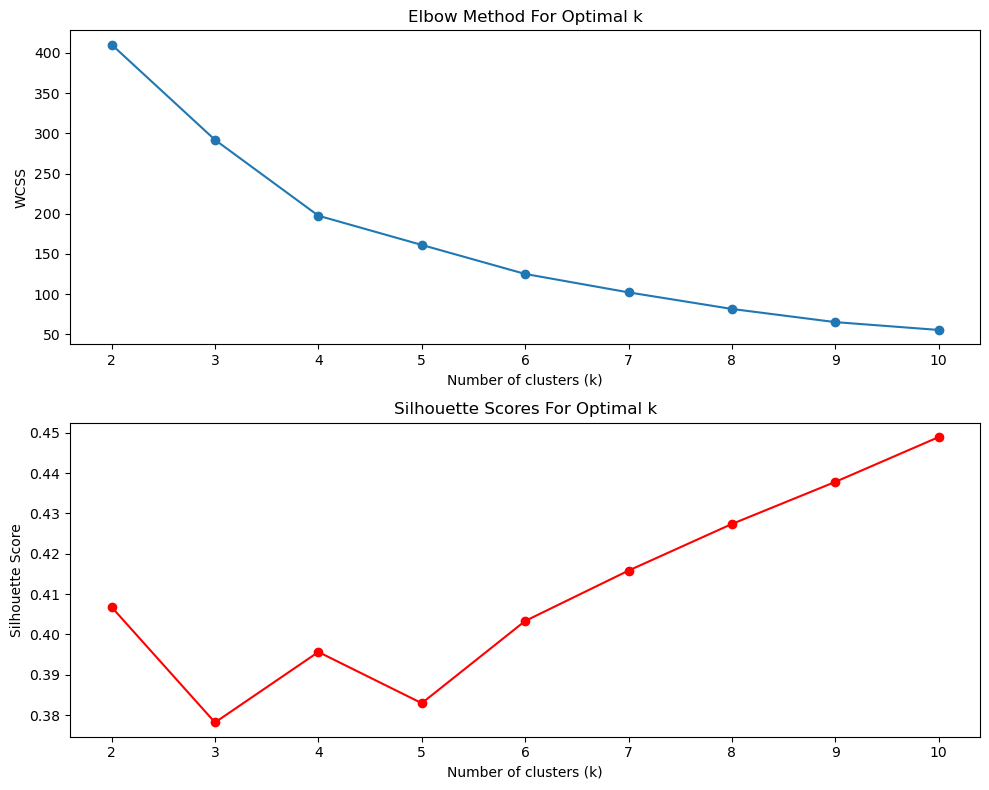

In [33]:

cluster_errors = []
silhouette_scores = []

for n_clusters in range(2, 11):
    # Create a KMeans instance with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, verbose=0)
    
    # Fit KMeans instance to scaled data
    kmeans.fit(scaled_values)
    
    # Calculate WCSS (Within-Cluster Sum of Square)
    wcsse = kmeans.inertia_
    print(f'K = {n_clusters}\tWCSS Err. = {wcsse}')
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_values, kmeans.labels_)
    print(f'K = {n_clusters}\tSilhouette Score = {silhouette_avg}')
    
    # Append the metrics to their respective lists
    cluster_errors.append(wcsse)
    silhouette_scores.append(silhouette_avg)

# Plotting WCSS
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(range(2, 11), cluster_errors, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

# Plotting Silhouette Scores
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()  # Adjusts the subplot layout for better readability
plt.show()


In [34]:
scaled_df.columns

Index(['Cameroon', 'Congo', 'Côte d'Ivoire',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone', 'Togo'],
      dtype='object', name='Country')